# Stage 2: Allocation

In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import os
import model_helpers
from multiprocesspandas import applyparallel
import matplotlib.pyplot as plt


from category_encoders import OneHotEncoder
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn import set_config
set_config(display="diagram")
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import GradientBoostingRegressor, AdaBoostRegressor
from xgboost import XGBRegressor

In [2]:
path = '../../data/clean/'
SEED = 12

## 1. Preprocessing and feature engineer

### Filtering the cleaned dataframe

In [3]:
df_full = pd.read_csv(path + 'unhcr.csv', engine='pyarrow').drop_duplicates(subset=['Id','year'])[['iso_o', 'iso_d','Id','year', 'newarrival']]# 'pop_o', 'CPI_o', 'GDP_PP_o', 'GDP_PPP_o',
        #'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o',
        #'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o',
        #'dead_log_o', 'Nyear_conf_o', 'dead_o', 'newarrival']]

df_full['year'] = pd.to_datetime(df_full['year'], format='%Y')
df_full["year"] = df_full["year"].dt.year
df_full = df_full.sort_values(by=['iso_o', 'iso_d','year'], ascending=[True, True, True])
df_full = df_full.reset_index(drop=True)
df_full

,iso_o,iso_d,Id,year,newarrival
0,ABW,AFG,ABWAFG,2000,0.0
1,ABW,AFG,ABWAFG,2001,0.0
2,ABW,AFG,ABWAFG,2002,0.0
3,ABW,AFG,ABWAFG,2003,0.0
4,ABW,AFG,ABWAFG,2004,0.0
...,...,...,...,...,...
955495,ZWE,ZMB,ZWEZMB,2020,1.0
955496,ZWE,ZMB,ZWEZMB,2021,0.0
955497,ZWE,ZMB,ZWEZMB,2022,0.0
955498,ZWE,ZMB,ZWEZMB,2023,0.0


### Generating outflows (train set) and importing best predictions for outflows (test set)

In [45]:
data_outflows_test = pd.read_csv("../../best predictions/outflows_best_rw (30-6).csv")
data_outflows_test = data_outflows_test[["year", "iso_o", "y_pred_gdelt_log_rw"]]
data_outflows_test = data_outflows_test.rename(columns={"y_pred_gdelt_log_rw":"ref_outflow"})
data_outflows = df_full.groupby(['iso_o', 'year']).newarrival.sum()
data_outflows = data_outflows.reset_index()
data_outflows = data_outflows.rename(columns={"newarrival":"ref_outflow"})

In [46]:
# Merge the two dataframes based on the common id variable
df_merged = df_full.merge(data_outflows, left_on=['iso_o','year'], right_on=['iso_o','year'])
df_merged = df_merged.sort_values(by=['iso_o', 'iso_d','year'], ascending=[True, True, True])
df_merged = df_merged.reset_index(drop=True)
df_merged = df_merged.rename(columns={'ref_outflow': 'ref_outflow_real'})




In [47]:
data_outflows = data_outflows.loc[data_outflows["year"] < 2018]
data_outflows = pd.concat([data_outflows, data_outflows_test])
data_outflows = data_outflows.sort_values(by=['iso_o', 'year'])
data_outflows = data_outflows.rename(columns={"ref_outflow":"ref_outflow_pred_test"})

In [49]:
df_merged = pd.merge(df_merged, data_outflows, on=["iso_o", "year"], how="left")

In [51]:
df_merged = df_merged.loc[df_merged["year"] <= 2021]
df_merged

,iso_o,iso_d,Id,year,newarrival,ref_outflow_real,ref_outflow_pred_test
0,ABW,AFG,ABWAFG,2000,0.0,0.0,0.000000
1,ABW,AFG,ABWAFG,2001,0.0,0.0,0.000000
2,ABW,AFG,ABWAFG,2002,0.0,0.0,0.000000
3,ABW,AFG,ABWAFG,2003,0.0,0.0,0.000000
4,ABW,AFG,ABWAFG,2004,0.0,0.0,0.000000
...,...,...,...,...,...,...,...
955492,ZWE,ZMB,ZWEZMB,2017,0.0,4523.0,4523.000000
955493,ZWE,ZMB,ZWEZMB,2018,2.0,1908.0,8368.098844
955494,ZWE,ZMB,ZWEZMB,2019,0.0,3371.0,7755.121701
955495,ZWE,ZMB,ZWEZMB,2020,1.0,1196.0,4784.420856


### Generate the ratio (% of people leaving in that year from iso_o to iso_d)

In [53]:
# First, we adjust newarrivals by the predicted refugee outflows to get the ratios to sum to 1
df_merged["newarrival_adj"] = df_merged["newarrival"]*df_merged["ref_outflow_pred_test"]/df_merged["ref_outflow_real"]
df_merged = df_merged.fillna(0)

C:\Users\danid\AppData\Local\Temp\ipykernel_40492\3844435073.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_merged["newarrival_adj"] = df_merged["newarrival"]*df_merged["ref_outflow_pred_test"]/df_merged["ref_outflow_real"]


In [55]:
# Create the ratio
df_merged['ratio'] = df_merged['newarrival_adj'] / df_merged['ref_outflow_pred_test']
df_merged['ratio'] = df_merged['ratio'].fillna(0)

# Create a new column 'check' by summing 'ratio' grouped by 'iso_o' and 'year'
df_merged['check'] = df_merged.groupby(['iso_o', 'year'])['ratio'].transform('sum')

# Example for Venezuela (check column must be 1)
df_merged[(df_merged['iso_o'] == 'VEN') & (df_merged['year'] == 2020)]

,iso_o,iso_d,Id,year,newarrival,ref_outflow_real,ref_outflow_pred_test,newarrival_adj,ratio,check
911645,VEN,ABW,VENABW,2020,1000.0,572356.0,143218.265001,250.225847,0.001747,1.0
911670,VEN,AFG,VENAFG,2020,0.0,572356.0,143218.265001,0.000000,0.000000,1.0
911695,VEN,AGO,VENAGO,2020,0.0,572356.0,143218.265001,0.000000,0.000000,1.0
911720,VEN,ALB,VENALB,2020,0.0,572356.0,143218.265001,0.000000,0.000000,1.0
911745,VEN,AND,VENAND,2020,0.0,572356.0,143218.265001,0.000000,0.000000,1.0
...,...,...,...,...,...,...,...,...,...,...
916395,VEN,WSM,VENWSM,2020,0.0,572356.0,143218.265001,0.000000,0.000000,1.0
916420,VEN,YEM,VENYEM,2020,0.0,572356.0,143218.265001,0.000000,0.000000,1.0
916445,VEN,ZAF,VENZAF,2020,0.0,572356.0,143218.265001,0.000000,0.000000,1.0
916470,VEN,ZMB,VENZMB,2020,0.0,572356.0,143218.265001,0.000000,0.000000,1.0


In [58]:
# But for those countries without refugee flows, the ratio is gonna be 0
df_merged[(df_merged['iso_o'] == 'ABW') & (df_merged['year'] == 2000)]

,iso_o,iso_d,Id,year,newarrival,ref_outflow_real,ref_outflow_pred_test,newarrival_adj,ratio,check
0,ABW,AFG,ABWAFG,2000,0.0,0.0,0.0,0.0,0.0,0.0
25,ABW,AGO,ABWAGO,2000,0.0,0.0,0.0,0.0,0.0,0.0
50,ABW,ALB,ABWALB,2000,0.0,0.0,0.0,0.0,0.0,0.0
75,ABW,AND,ABWAND,2000,0.0,0.0,0.0,0.0,0.0,0.0
100,ABW,ARE,ABWARE,2000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
4750,ABW,WSM,ABWWSM,2000,0.0,0.0,0.0,0.0,0.0,0.0
4775,ABW,YEM,ABWYEM,2000,0.0,0.0,0.0,0.0,0.0,0.0
4800,ABW,ZAF,ABWZAF,2000,0.0,0.0,0.0,0.0,0.0,0.0
4825,ABW,ZMB,ABWZMB,2000,0.0,0.0,0.0,0.0,0.0,0.0


In [59]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
Index: 840840 entries, 0 to 955496
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   iso_o                  840840 non-null  object 
 1   iso_d                  840840 non-null  object 
 2   Id                     840840 non-null  object 
 3   year                   840840 non-null  int32  
 4   newarrival             840840 non-null  float64
 5   ref_outflow_real       840840 non-null  float64
 6   ref_outflow_pred_test  840840 non-null  float64
 7   newarrival_adj         840840 non-null  float64
 8   ratio                  840840 non-null  float64
 9   check                  840840 non-null  float64
dtypes: float64(6), int32(1), object(3)
memory usage: 67.4+ MB


### Missing values between 2000-2021

In [826]:
# mask = df_merged['year'] <= 2021

# # Replace NaN values in the "newarrival" column with the previous non-null value, only for the masked rows
# df_merged.loc[mask, 'newarrival'].fillna(method='ffill', inplace=True)

In [26]:
# df_merged[(df_merged['iso_o'] == 'ABW') & (df_merged['year'] == 2022)]

## 2. Modeling `ratio`

In [60]:
# Data manipulation
# ==============================================================================
import numpy as np
import pandas as pd

# Plots
# ==============================================================================
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

# Modeling and Forecasting
# ==============================================================================
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

from skforecast.ForecasterAutoreg import ForecasterAutoreg
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect
from skforecast.model_selection import grid_search_forecaster
from skforecast.model_selection import backtesting_forecaster
from skforecast.utils import save_forecaster
from skforecast.utils import load_forecaster

# Warnings configuration
# ==============================================================================
import warnings
# warnings.filterwarnings('ignore')

In [244]:
# Important Definitions
# Period
start_year = 2018
end_year = 2021 # end_year = df_merged['year'].max()

# Autorregresive inputs
# lags = 4   # AR(4)
lags = 4
steps = end_year - start_year + 1  # Forecast horizon

In [62]:
# Remove the "newarrival" column and assign it to a variable
newarrival_column = df_merged.pop('newarrival')

# Move the "newarrival" column to the end of the DataFrame
df_merged['newarrival'] = newarrival_column
df_merged

,iso_o,iso_d,Id,year,ref_outflow_real,ref_outflow_pred_test,newarrival_adj,ratio,check,newarrival
0,ABW,AFG,ABWAFG,2000,0.0,0.000000,0.000000,0.000000,0.0,0.0
1,ABW,AFG,ABWAFG,2001,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,ABW,AFG,ABWAFG,2002,0.0,0.000000,0.000000,0.000000,0.0,0.0
3,ABW,AFG,ABWAFG,2003,0.0,0.000000,0.000000,0.000000,0.0,0.0
4,ABW,AFG,ABWAFG,2004,0.0,0.000000,0.000000,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
955492,ZWE,ZMB,ZWEZMB,2017,4523.0,4523.000000,0.000000,0.000000,1.0,0.0
955493,ZWE,ZMB,ZWEZMB,2018,1908.0,8368.098844,8.771592,0.001048,1.0,2.0
955494,ZWE,ZMB,ZWEZMB,2019,3371.0,7755.121701,0.000000,0.000000,1.0,0.0
955495,ZWE,ZMB,ZWEZMB,2020,1196.0,4784.420856,4.000352,0.000836,1.0,1.0


### Subsample

In [63]:
len(df_merged['Id'].unique())

38220

In [832]:
# Get the first 10 unique "Id" values
#first_10_ids = df_merged['Id'].unique()[35000:]

# Filter the dataframe for the first 10 "Id" values
#df_merged = df_merged[df_merged['Id'].isin(first_10_ids)]
#df_merged

## 2.1 Naive Model

In [64]:
# Store the list of countries to predict
ids = df_merged['Id'].unique().tolist()
len(ids)

38220

In [65]:
# Create train/test split
train = df_merged.loc[df_merged.year < start_year]
test = df_merged.loc[(df_merged.year >= start_year) & (df_merged.year <= end_year)]

In [66]:
y_naive = model_helpers.apply_naive_prediction(train, test, target="newarrival", lst_countries=ids,
                                              country_var='Id'
                                              )

In [67]:
data = {'Id': test.Id,
        'year': test.year,
        'fcast_newarrival_naive': y_naive}
df_forecast_naive = pd.DataFrame(data)

# Create new dataframe with forecasted values
df_forecast = df_merged.loc[df_merged.year <= end_year]
df_forecast = pd.merge(df_forecast, df_forecast_naive, on=['Id', 'year'], how='outer')
df_forecast

,iso_o,iso_d,Id,year,ref_outflow_real,ref_outflow_pred_test,newarrival_adj,ratio,check,newarrival,fcast_newarrival_naive
0,ABW,AFG,ABWAFG,2000,0.0,0.000000,0.000000,0.000000,0.0,0.0,NaN
1,ABW,AFG,ABWAFG,2001,0.0,0.000000,0.000000,0.000000,0.0,0.0,NaN
2,ABW,AFG,ABWAFG,2002,0.0,0.000000,0.000000,0.000000,0.0,0.0,NaN
3,ABW,AFG,ABWAFG,2003,0.0,0.000000,0.000000,0.000000,0.0,0.0,NaN
4,ABW,AFG,ABWAFG,2004,0.0,0.000000,0.000000,0.000000,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
840835,ZWE,ZMB,ZWEZMB,2017,4523.0,4523.000000,0.000000,0.000000,1.0,0.0,NaN
840836,ZWE,ZMB,ZWEZMB,2018,1908.0,8368.098844,8.771592,0.001048,1.0,2.0,0.0
840837,ZWE,ZMB,ZWEZMB,2019,3371.0,7755.121701,0.000000,0.000000,1.0,0.0,2.0
840838,ZWE,ZMB,ZWEZMB,2020,1196.0,4784.420856,4.000352,0.000836,1.0,1.0,0.0


## 2.2 AR Model without covariates

In [88]:
from tqdm.notebook import trange, tqdm

Including a rolling window forecast

In [108]:
import warnings

# Temporarily suppress the SettingWithCopyWarning
warnings.filterwarnings("ignore")

forecast_data = pd.DataFrame(columns=['Id', 'year', 'fcast_ratio_ar'])

# Loop over pairs of countries
for country in tqdm(df_merged["Id"].unique()):
    # Subset training for specific country
    training = df_merged[df_merged["Id"] == country]
    # Set index for time variable
    training['year'] = pd.to_datetime(training['year'], format='%Y')
    training = training.set_index('year')
    training = training.asfreq('AS')

    # If the previous value was 0, forecast 0
    if training["ratio"].iloc[-1] == 0:
        # Iterate over the four-year forecast values
        for i in range(4):
            year = 2018 + i
            forecast_value = 0  # Assuming forecast_values is a list of length 4
            
            # Create a dictionary with the data
            dict_data = {'Id': country, 'year': year, 'fcast_ratio_ar': forecast_value}
            dict_data = pd.DataFrame([dict_data])
            forecast_data = pd.concat([forecast_data, dict_data], ignore_index=True)

    else: 
        # Create and train forecaster with exogenous variables
        regressor = RandomForestRegressor(max_depth=3, n_estimators=50, random_state=123, n_jobs=-1)
        forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)

        # Iterate over the four-year forecast values
        for i in range(4):
            year = 2018 + i

            # Select the training data up until the previous year
            training_data = training[training.index < pd.to_datetime(str(year), format='%Y')]

            if len(training_data) > 0:
                forecaster.fit(y=training_data['ratio'])  # Train the forecaster

                # Produce out-of-sample forecast for the next year
                prediction = forecaster.predict(steps=1)

                forecast_value = prediction.values[-1]

            else:
                # If there is no training data, forecast 0
                forecast_value = 0

            # Create a dictionary with the data
            dict_data = {'Id': country, 'year': year, 'fcast_ratio_ar': forecast_value}
            dict_data = pd.DataFrame([dict_data])
            forecast_data = pd.concat([forecast_data, dict_data], ignore_index=True)

warnings.resetwarnings()


  0%|          | 0/38220 [00:00<?, ?it/s]

In [110]:
forecast_data = forecast_data.rename(columns={"fcast_ratio_ar":"fcast_ratio_ar_10"})
forecast_data

,Id,year,fcast_ratio_ar_10
0,ABWAFG,2018,0
1,ABWAFG,2019,0
2,ABWAFG,2020,0
3,ABWAFG,2021,0
4,ABWAGO,2018,0
...,...,...,...
152875,ZWEZAF,2021,0
152876,ZWEZMB,2018,0
152877,ZWEZMB,2019,0
152878,ZWEZMB,2020,0


In [112]:

df_forecast = pd.merge(df_forecast, forecast_data, on=['Id', 'year'], how='outer')

# Create the newarrival forecast and save
ratio_column = df_forecast.pop('fcast_ratio_ar_10')
df_forecast.insert(7, 'fcast_ratio_ar_10', ratio_column)

df_forecast['fcast_newarrival_ar_10'] = df_forecast['newarrival'] * df_forecast['fcast_ratio_ar_10']

In [114]:
df_forecast.to_csv("../../best predictions/df_forecast_alloc_naive_ar_10.csv", index=False)

### Version including covariates

In [179]:
# Import covariates
# unhcr + trends for cities and neighboring countries (preprocessed)
unhcr = pd.read_csv(path + "dyad_df (partial).csv")

# visa gtrends
visa = pd.read_csv(path + "visa_interacted_preprocessed.csv")


In [180]:
print(list(unhcr.columns))

['Unnamed: 0', 'iso_o', 'iso_d', 'year', 'Id', 'newarrival', 'comlang_ethno', 'colony', 'comcol', 'col45', 'smctry', 'dist', 'index0asylum', 'contig', 'comlang_off', 'degrees_of_separation', 'Shift_1_newarrival', 'Shift_2_newarrival', 'Shift_3_newarrival', 'rolling_sum_past_3_newarrival', 'rolling_sum_past_5_newarrival', 'rolling_sum_past_10_newarrival', 'Unnamed: 22', 'pop_o', 'CPI_o', 'GDP_PP_o', 'Country_o', 'GDP_PPP_o', 'island_o', 'area_o', 'landlocked_o', 'PR_o', 'CL_o', 'typeOfViolence_o', 'best_est_o', 'Nyear_conflict_o', 'Nyear_log_o', 'dead_log_o', 'Nyear_conf_o', 'dead_o', 'pop_d', 'CPI_d', 'GDP_PP_d', 'Country_d', 'GDP_PPP_d', 'island_d', 'area_d', 'landlocked_d', 'PR_d', 'CL_d', 'typeOfViolence_d', 'best_est_d', 'Nyear_conflict_d', 'Nyear_log_d', 'dead_log_d', 'Nyear_conf_d', 'dead_d', 'Shift_1_CPI_d', 'Shift_1_GDP_PP_d', 'Shift_1_GDP_PPP_d', 'Shift_1_PR_d', 'Shift_1_CL_d', 'Shift_1_Nyear_conflict_d', 'Shift_1_Nyear_log_d', 'Shift_1_typeOfViolence_d', 'Shift_1_Nyear_conf_d

In [181]:
unhcr = unhcr.drop(columns=['Unnamed: 0', 'Shift_1_newarrival', 'Shift_2_newarrival', 'Shift_3_newarrival',
'Unnamed: 22', 'Country_o', 'Country_d', 'newarrival'])

In [182]:
# To merge the covariates one year before their actual value, I shift the year column +1
unhcr.year = unhcr.groupby('Id').year.shift(1)

In [183]:
# First, drop duplicates in the 'unhcr' DataFrame based on the key columns
unhcr_no_duplicates = unhcr.drop_duplicates(subset=['Id', 'year', 'iso_o', 'iso_d'], keep='first')

# Now, perform the merge with the 'unhcr_no_duplicates' DataFrame
df_merged_covs = pd.merge(df_merged, unhcr_no_duplicates, on=['Id', 'year', 'iso_o', 'iso_d'], how='left')


In [184]:
print(df_merged_covs.shape)
print(df_merged.shape)

(840840, 99)
(840840, 10)


In [185]:
# To merge the covariates one year before their actual value, I shift the year column +1
visa.year = visa.groupby(['iso_o', 'iso_d']).year.shift(1)
visa = visa.drop(columns=['internet', 'pop_o'])
visa_no_duplicates = visa.drop_duplicates(subset=['year', 'iso_o', 'iso_d'], keep='first')
df_merged_covs = pd.merge(df_merged_covs, visa_no_duplicates, on=['year', 'iso_o', 'iso_d'], how='left')
df_merged_covs.shape

In [232]:
cols_covs = df_merged_covs.columns.tolist()
cols_merged = df_merged.columns.tolist()
covariates_cols = list(set(cols_covs) - set(cols_merged))



In [240]:
from category_encoders import BinaryEncoder
from sklearn.preprocessing import RobustScaler

binary_cols = ['typeOfViolence_o', 'typeOfViolence_d', 'Id', 'iso_o', 'iso_d', 'iso_d_continent']
be = BinaryEncoder(cols=binary_cols)
cont_scaler = RobustScaler()
numerical_cols = list(set(covariates_cols) - set(binary_cols))
# Fit and transform binary encoding
transformed_binary = be.fit_transform(df_merged_covs)

# Scale the numerical columns
transformed_numerical = cont_scaler.fit_transform(df_merged_covs[numerical_cols])

# Concatenate the transformed data
transformed_data = pd.concat([transformed_binary, pd.DataFrame(transformed_numerical, columns=numerical_cols)], axis=1)

# Optionally, include the ['year', 'target'] columns in the final dataset
transformed_data[cols_merged] = df_merged_covs[cols_merged]

# Optionally, if you want to set the index back to the original index
# transformed_data.index = df_merged_covs.index

transformed_data.head()


,iso_o_0,iso_o_1,iso_o_2,iso_o_3,iso_o_4,iso_o_5,iso_o_6,iso_o_7,iso_d_0,iso_d_1,...,country_trend,Shift_2_GDP_PPP_d,comlang_off,CPI_d,Shift_1_CL_d,country_trend_max,rolling_sum_past_3_newarrival,iso_o,iso_d,Id
0,0,0,0,0,0,0,0,1,0,0,...,NaN,-0.213058,0.0,-361.987018,-0.333333,NaN,0.0,ABW,AFG,ABWAFG
1,0,0,0,0,0,0,0,1,0,0,...,NaN,-0.206186,0.0,110.917638,-0.333333,NaN,0.0,ABW,AFG,ABWAFG
2,0,0,0,0,0,0,0,1,0,0,...,NaN,-0.206186,0.0,0.508675,-0.333333,NaN,0.0,ABW,AFG,ABWAFG
3,0,0,0,0,0,0,0,1,0,0,...,NaN,-0.209622,0.0,1.665865,-0.333333,NaN,0.0,ABW,AFG,ABWAFG
4,0,0,0,0,0,0,0,1,0,0,...,NaN,-0.209622,0.0,1.201340,-0.333333,NaN,0.0,ABW,AFG,ABWAFG


In [242]:
cols_covs = transformed_data.columns.tolist()
cols_merged = df_merged.columns.tolist()
covariates_cols = list(set(cols_covs) - set(cols_merged))

In [250]:
transformed_data = transformed_data.loc[transformed_data['year'] >=2005]

In [253]:
transformed_data = transformed_data.fillna(0)

In [258]:
import warnings

# Temporarily suppress the SettingWithCopyWarning
warnings.filterwarnings("ignore")

forecast_data = pd.DataFrame(columns=['Id', 'year', 'fcast_ratio_ar'])

# Loop over pairs of countries
for country in tqdm(transformed_data["Id"].unique()):
    # Subset training for specific country
    training = transformed_data[transformed_data["Id"] == country]
    # Set index for time variable
    training['year'] = pd.to_datetime(training['year'], format='%Y')
    training = training.set_index('year')
    training = training.asfreq('AS')

    # If the previous value was 0, forecast 0
    if training["ratio"].iloc[-1] == 0:
        # Iterate over the four-year forecast values
        for i in range(4):
            year = 2018 + i
            forecast_value = 0  # Assuming forecast_values is a list of length 4
            
            # Create a dictionary with the data
            dict_data = {'Id': country, 'year': year, 'fcast_ratio_ar': forecast_value}
            dict_data = pd.DataFrame([dict_data])
            forecast_data = pd.concat([forecast_data, dict_data], ignore_index=True)

    else: 
        # Create and train forecaster with exogenous variables
        regressor = RandomForestRegressor(max_depth=3, n_estimators=50, random_state=123, n_jobs=-1)
        forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)

        # Iterate over the four-year forecast values
        for i in range(4):
            year = 2018 + i

            # Select the training data up until the previous year
            training_data = training[training.index < pd.to_datetime(str(year), format='%Y')]
            exog_training = training_data[covariates_cols]
            test_data_exog = training[training.index == pd.to_datetime(str(year), format='%Y')]
            exog_test = test_data_exog[covariates_cols]
            if len(training_data) > 0:
                forecaster.fit(y=training_data['ratio'], exog=exog_training)  # Train the forecaster

                # Produce out-of-sample forecast for the next year
                prediction = forecaster.predict(steps=1, exog=exog_test)

                forecast_value = prediction.values[-1]

            else:
                # If there is no training data, forecast 0
                forecast_value = 0

            # Create a dictionary with the data
            dict_data = {'Id': country, 'year': year, 'fcast_ratio_ar': forecast_value}
            dict_data = pd.DataFrame([dict_data])
            forecast_data = pd.concat([forecast_data, dict_data], ignore_index=True)

warnings.resetwarnings()


  0%|          | 0/38220 [00:00<?, ?it/s]

In [261]:
forecast_data = forecast_data.rename(columns={"fcast_ratio_ar":"fcast_ratio_ar_covs"})

In [262]:
df_forecast = pd.merge(df_forecast, forecast_data, on=['Id', 'year'], how='outer')

# Create the newarrival forecast and save
ratio_column = df_forecast.pop('fcast_ratio_ar_covs')
df_forecast.insert(7, 'fcast_ratio_ar_covs', ratio_column)

df_forecast['fcast_newarrival_ar_covs'] = df_forecast['newarrival'] * df_forecast['fcast_ratio_ar_covs']

#### Testing GradientBoosting instead of RF as regressor

In [270]:
import warnings

# Temporarily suppress the SettingWithCopyWarning
warnings.filterwarnings("ignore")

forecast_data = pd.DataFrame(columns=['Id', 'year', 'fcast_ratio_ar'])

# Loop over pairs of countries
for country in tqdm(transformed_data["Id"].unique()):
    # Subset training for specific country
    training = transformed_data[transformed_data["Id"] == country]
    # Set index for time variable
    training['year'] = pd.to_datetime(training['year'], format='%Y')
    training = training.set_index('year')
    training = training.asfreq('AS')

    # If the previous value was 0, forecast 0
    if training["ratio"].iloc[-1] == 0:
        # Iterate over the four-year forecast values
        for i in range(4):
            year = 2018 + i
            forecast_value = 0  # Assuming forecast_values is a list of length 4
            
            # Create a dictionary with the data
            dict_data = {'Id': country, 'year': year, 'fcast_ratio_ar': forecast_value}
            dict_data = pd.DataFrame([dict_data])
            forecast_data = pd.concat([forecast_data, dict_data], ignore_index=True)

    else: 
        # Create and train forecaster with exogenous variables
        regressor = GradientBoostingRegressor(random_state=123)
        forecaster = ForecasterAutoreg(regressor=regressor, lags=lags)

        # Iterate over the four-year forecast values
        for i in range(4):
            year = 2018 + i

            # Select the training data up until the previous year
            training_data = training[training.index < pd.to_datetime(str(year), format='%Y')]
            exog_training = training_data[covariates_cols]
            test_data_exog = training[training.index == pd.to_datetime(str(year), format='%Y')]
            exog_test = test_data_exog[covariates_cols]
            if len(training_data) > 0:
                forecaster.fit(y=training_data['ratio'], exog=exog_training)  # Train the forecaster

                # Produce out-of-sample forecast for the next year
                prediction = forecaster.predict(steps=1, exog=exog_test)

                forecast_value = prediction.values[-1]

            else:
                # If there is no training data, forecast 0
                forecast_value = 0

            # Create a dictionary with the data
            dict_data = {'Id': country, 'year': year, 'fcast_ratio_ar': forecast_value}
            dict_data = pd.DataFrame([dict_data])
            forecast_data = pd.concat([forecast_data, dict_data], ignore_index=True)

warnings.resetwarnings()

  0%|          | 0/38220 [00:00<?, ?it/s]

In [271]:
forecast_data = forecast_data.rename(columns={"fcast_ratio_ar":"fcast_ratio_ar_covs_gb"})

c:\Users\danid\anaconda3\envs\master_thesis\Lib\site-packages\skforecast\ForecasterAutoreg\ForecasterAutoreg.py:1295: UserWarning: get_feature_importance() method has been renamed to get_feature_importances(). This method will be removed in skforecast 0.9.0.
  warnings.warn(


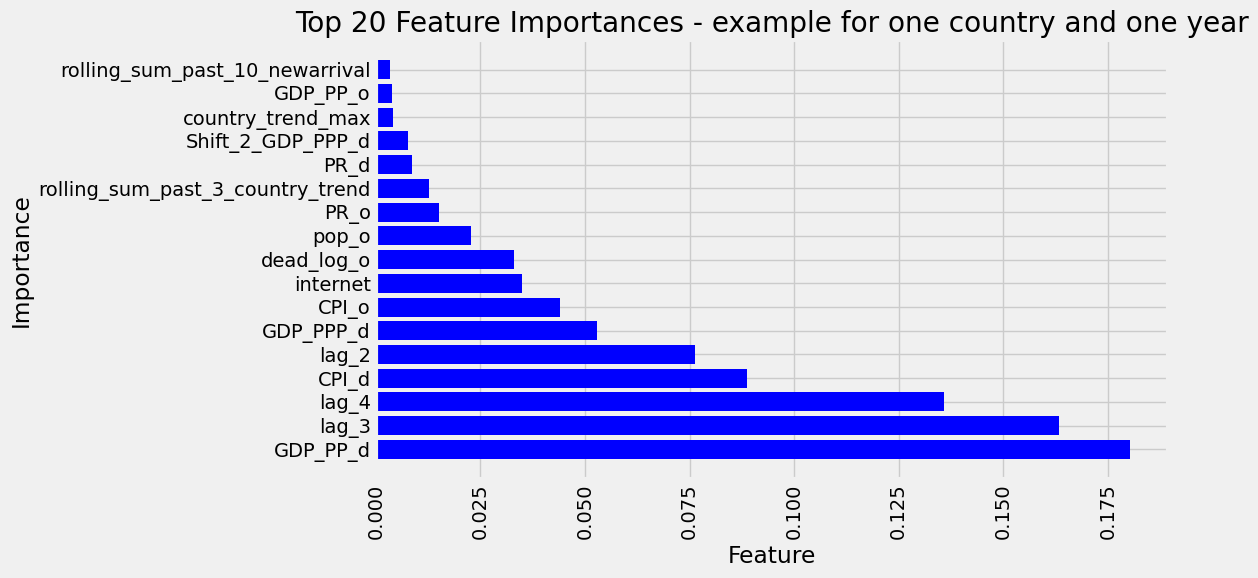

In [303]:

# Map feature importances to column names
feature_importances = forecaster.get_feature_importance()

sorted_df = feature_importances.sort_values(by='importance', ascending=False)
top_20 = sorted_df.head(20)

# Create a bar chart
plt.figure(figsize=(12, 6))
plt.barh(top_20['feature'], top_20['importance'], color='blue')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 20 Feature Importances - example for one country and one year')
plt.tight_layout()
plt.show()


In [272]:
df_forecast = pd.merge(df_forecast, forecast_data, on=['Id', 'year'], how='outer')

# Create the newarrival forecast and save
ratio_column = df_forecast.pop('fcast_ratio_ar_covs_gb')
df_forecast.insert(7, 'fcast_ratio_ar_covs_gb', ratio_column)

df_forecast['fcast_newarrival_ar_covs_gb'] = df_forecast['newarrival'] * df_forecast['fcast_ratio_ar_covs_gb']

## Start here

In [273]:
# df_forecast = pd.read_csv('../../best predictions/df_forecast_alloc_naive.csv', index_col=None)
df_forecast

,iso_o,iso_d,Id,year,ref_outflow_real,ref_outflow_pred_test,newarrival_adj,fcast_ratio_ar_covs_gb,fcast_ratio_ar_covs,fcast_ratio_ar_10,fcast_ratio_ar,ratio,check,newarrival,fcast_newarrival_naive,fcast_newarrival_ar,fcast_newarrival_ar_10,fcast_newarrival_ar_covs,fcast_newarrival_ar_covs_gb
0,ABW,AFG,ABWAFG,2000,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,ABW,AFG,ABWAFG,2001,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
2,ABW,AFG,ABWAFG,2002,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
3,ABW,AFG,ABWAFG,2003,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
4,ABW,AFG,ABWAFG,2004,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,0.0,0.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840835,ZWE,ZMB,ZWEZMB,2017,4523.0,4523.000000,0.000000,NaN,NaN,NaN,NaN,0.000000,1.0,0.0,NaN,NaN,NaN,NaN,NaN
840836,ZWE,ZMB,ZWEZMB,2018,1908.0,8368.098844,8.771592,0,0,0,0.0,0.001048,1.0,2.0,0.0,0.0,0.0,0.0,0.0
840837,ZWE,ZMB,ZWEZMB,2019,3371.0,7755.121701,0.000000,0,0,0,0.0,0.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0
840838,ZWE,ZMB,ZWEZMB,2020,1196.0,4784.420856,4.000352,0,0,0,0.0,0.000836,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [274]:
df_cleaned = df_forecast.loc[(df_forecast.year >= start_year) & (df_forecast.year <= end_year)]
df_cleaned.fillna(0, inplace=True)
df_cleaned

C:\Users\danid\AppData\Local\Temp\ipykernel_40492\4094563266.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned.fillna(0, inplace=True)


,iso_o,iso_d,Id,year,ref_outflow_real,ref_outflow_pred_test,newarrival_adj,fcast_ratio_ar_covs_gb,fcast_ratio_ar_covs,fcast_ratio_ar_10,fcast_ratio_ar,ratio,check,newarrival,fcast_newarrival_naive,fcast_newarrival_ar,fcast_newarrival_ar_10,fcast_newarrival_ar_covs,fcast_newarrival_ar_covs_gb
18,ABW,AFG,ABWAFG,2018,0.0,5.070278e-07,0.000000,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19,ABW,AFG,ABWAFG,2019,1.0,1.049848e-03,0.000000,0,0,0,0.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
20,ABW,AFG,ABWAFG,2020,0.0,2.592607e-05,0.000000,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,ABW,AFG,ABWAFG,2021,0.0,3.357275e-05,0.000000,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,ABW,AGO,ABWAGO,2018,0.0,5.070278e-07,0.000000,0,0,0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840817,ZWE,ZAF,ZWEZAF,2021,640.0,1.469740e+03,0.000000,0,0,0,0.0,0.000000,1.0,0.0,214.0,0.0,0.0,0.0,0.0
840836,ZWE,ZMB,ZWEZMB,2018,1908.0,8.368099e+03,8.771592,0,0,0,0.0,0.001048,1.0,2.0,0.0,0.0,0.0,0.0,0.0
840837,ZWE,ZMB,ZWEZMB,2019,3371.0,7.755122e+03,0.000000,0,0,0,0.0,0.000000,1.0,0.0,2.0,0.0,0.0,0.0,0.0
840838,ZWE,ZMB,ZWEZMB,2020,1196.0,4.784421e+03,4.000352,0,0,0,0.0,0.000836,1.0,1.0,0.0,0.0,0.0,0.0,0.0


In [265]:
mse_naive = mean_squared_error(y_pred = df_cleaned['fcast_newarrival_naive'], y_true = df_cleaned['newarrival'], squared = False)
mse_ar = mean_squared_error(y_pred = df_cleaned['fcast_newarrival_ar_10'], y_true = df_cleaned['newarrival'], squared = False)
print("MSE Naive Model: " + str(mse_naive))
print("MSE Simple AR Model: " + str(mse_ar))

MSE Naive Model: 4705.086802344058
MSE Simple AR Model: 3957.9296955303553


In [118]:
mse_naive = mean_squared_error(y_pred = df_cleaned['fcast_newarrival_naive'], y_true = df_cleaned['newarrival'], squared = False)
mse_ar = mean_squared_error(y_pred = df_cleaned['fcast_newarrival_ar'], y_true = df_cleaned['newarrival'], squared = False)
print("MSE Naive Model: " + str(mse_naive))
print("MSE Simple AR Model: " + str(mse_ar))

MSE Naive Model: 4705.086802344058
MSE Simple AR Model: 3932.2142071805893


In [119]:
mse_ar/mse_naive

0.8357368040950007

In [266]:
mse_naive = mean_squared_error(y_pred = df_cleaned['fcast_newarrival_naive'], y_true = df_cleaned['newarrival'], squared = False)
mse_ar = mean_squared_error(y_pred = df_cleaned['fcast_newarrival_ar_covs'], y_true = df_cleaned['newarrival'], squared = False)
print("MSE Naive Model: " + str(mse_naive))
print("MSE Covs AR Model: " + str(mse_ar))

MSE Naive Model: 4705.086802344058
MSE Covs AR Model: 3894.155105958944


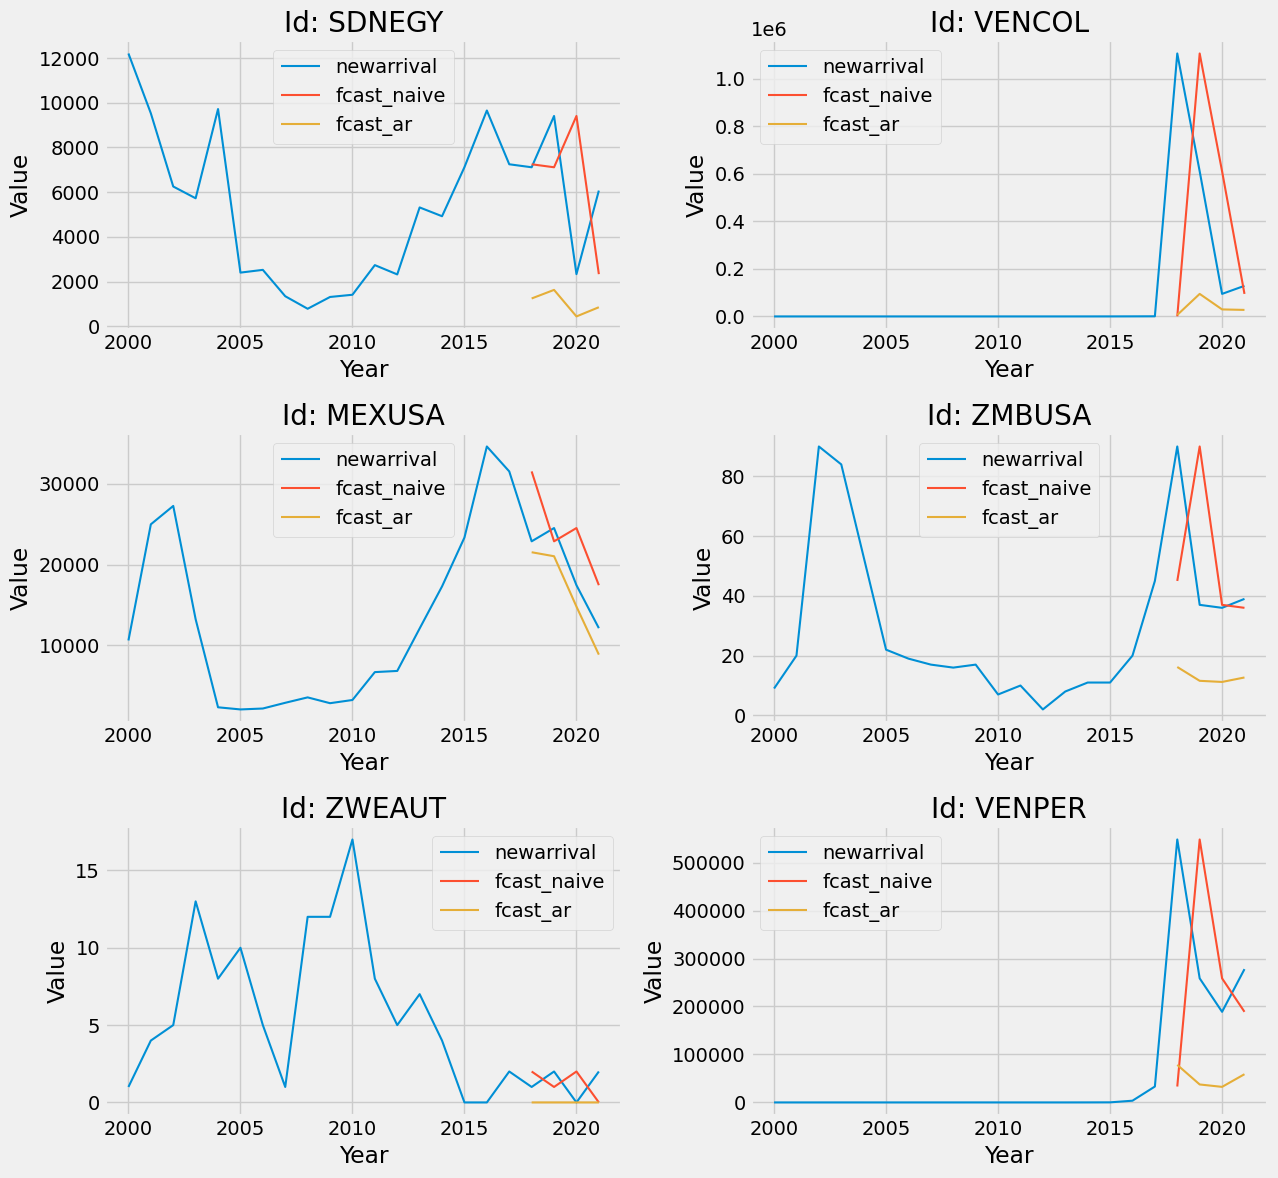

In [268]:
import matplotlib.pyplot as plt

# Assuming you have a panel DataFrame called "df_merged_data" with columns "Id", "year", "newarrival", and "fcast_newarrival_ar"

# Get unique "Id" values from the DataFrame
#unique_ids = df_merged_data['Id'].unique()
unique_ids = ['SDNEGY','VENCOL','MEXUSA','ZMBUSA','ZWEAUT','VENPER']

# Create a figure with subplots for each "Id"
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13, 12))

# Iterate over the unique "Id" values and plot the data
for i, id_value in enumerate(unique_ids):
    # Select the data for the current "Id"
    data = df_forecast[df_forecast['Id'] == id_value]
    
    # Get the corresponding subplot axis
    #ax = axes[i]
    ax = axes[i // 2, i % 2]
    
    # Plot "newarrival" and "fcast_newarrival_ar" values over time
    ax.plot(data['year'], data['newarrival'], label='newarrival')
    ax.plot(data['year'], data['fcast_newarrival_naive'], label='fcast_naive')
    ax.plot(data['year'], data['fcast_newarrival_ar_covs'], label='fcast_ar')
    
    # Set plot title and axis labels
    ax.set_title(f'Id: {id_value}')
    ax.set_xlabel('Year')
    ax.set_ylabel('Value')
    
    # Display legend
    ax.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


### Continents

In [844]:
continents = df_forecast[['iso_o']].apply(lambda x: model_helpers.mapper(x, model_helpers.country_to_continent)).rename({'iso_o':'continent_o'}, axis=1)
df_forecast = pd.concat([continents, df_forecast], axis=1)
df_forecast

,continent_o,Unnamed: 0,iso_o,iso_d,Id,year,ref_outflow,ratio,check,fcast_ratio_ar,newarrival,fcast_newarrival_naive,fcast_newarrival_ar
0,NA,0,ABW,AFG,ABWAFG,2000,0.0,0.000000,0.0,NaN,0.0,NaN,NaN
1,NA,1,ABW,AFG,ABWAFG,2001,0.0,0.000000,0.0,NaN,0.0,NaN,NaN
2,NA,2,ABW,AFG,ABWAFG,2002,0.0,0.000000,0.0,NaN,0.0,NaN,NaN
3,NA,3,ABW,AFG,ABWAFG,2003,0.0,0.000000,0.0,NaN,0.0,NaN,NaN
4,NA,4,ABW,AFG,ABWAFG,2004,0.0,0.000000,0.0,NaN,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
840835,AF,840835,ZWE,ZMB,ZWEZMB,2017,4523.0,0.000000,1.0,NaN,0.0,NaN,NaN
840836,AF,840836,ZWE,ZMB,ZWEZMB,2018,1908.0,0.001048,1.0,0.000125,2.0,0.0,0.238036
840837,AF,840837,ZWE,ZMB,ZWEZMB,2019,3371.0,0.000000,1.0,0.000331,0.0,2.0,1.115228
840838,AF,840838,ZWE,ZMB,ZWEZMB,2020,1196.0,0.000836,1.0,0.000199,1.0,0.0,0.238234


In [845]:
# Define a custom aggregation function to sum while considering NaN values
def sum_with_nan(series):
    return series.sum(min_count=1)

# Group the DataFrame by "continent_o" and "year", and apply the custom aggregation function to the desired variables
grouped = df_forecast.groupby(['continent_o', 'year'])['newarrival', 'fcast_newarrival_naive', 'fcast_newarrival_ar'].agg(sum_with_nan)

# Reset the index to have "continent_o" and "year" as columns
grouped = grouped.reset_index()
grouped

/tmp/ipykernel_2947/4250555984.py:6: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  grouped = df_forecast.groupby(['continent_o', 'year'])['newarrival', 'fcast_newarrival_naive', 'fcast_newarrival_ar'].agg(sum_with_nan)


,continent_o,year,newarrival,fcast_newarrival_naive,fcast_newarrival_ar
0,AF,2000,645426.0,NaN,NaN
1,AF,2001,416741.0,NaN,NaN
2,AF,2002,568101.0,NaN,NaN
3,AF,2003,515585.0,NaN,NaN
4,AF,2004,406924.0,NaN,NaN
...,...,...,...,...,...
127,SA,2017,156109.0,NaN,NaN
128,SA,2018,2545005.5,156109.0,2.158185e+06
129,SA,2019,1594536.0,2545005.5,1.352760e+06
130,SA,2020,635905.0,1594536.0,5.645141e+05


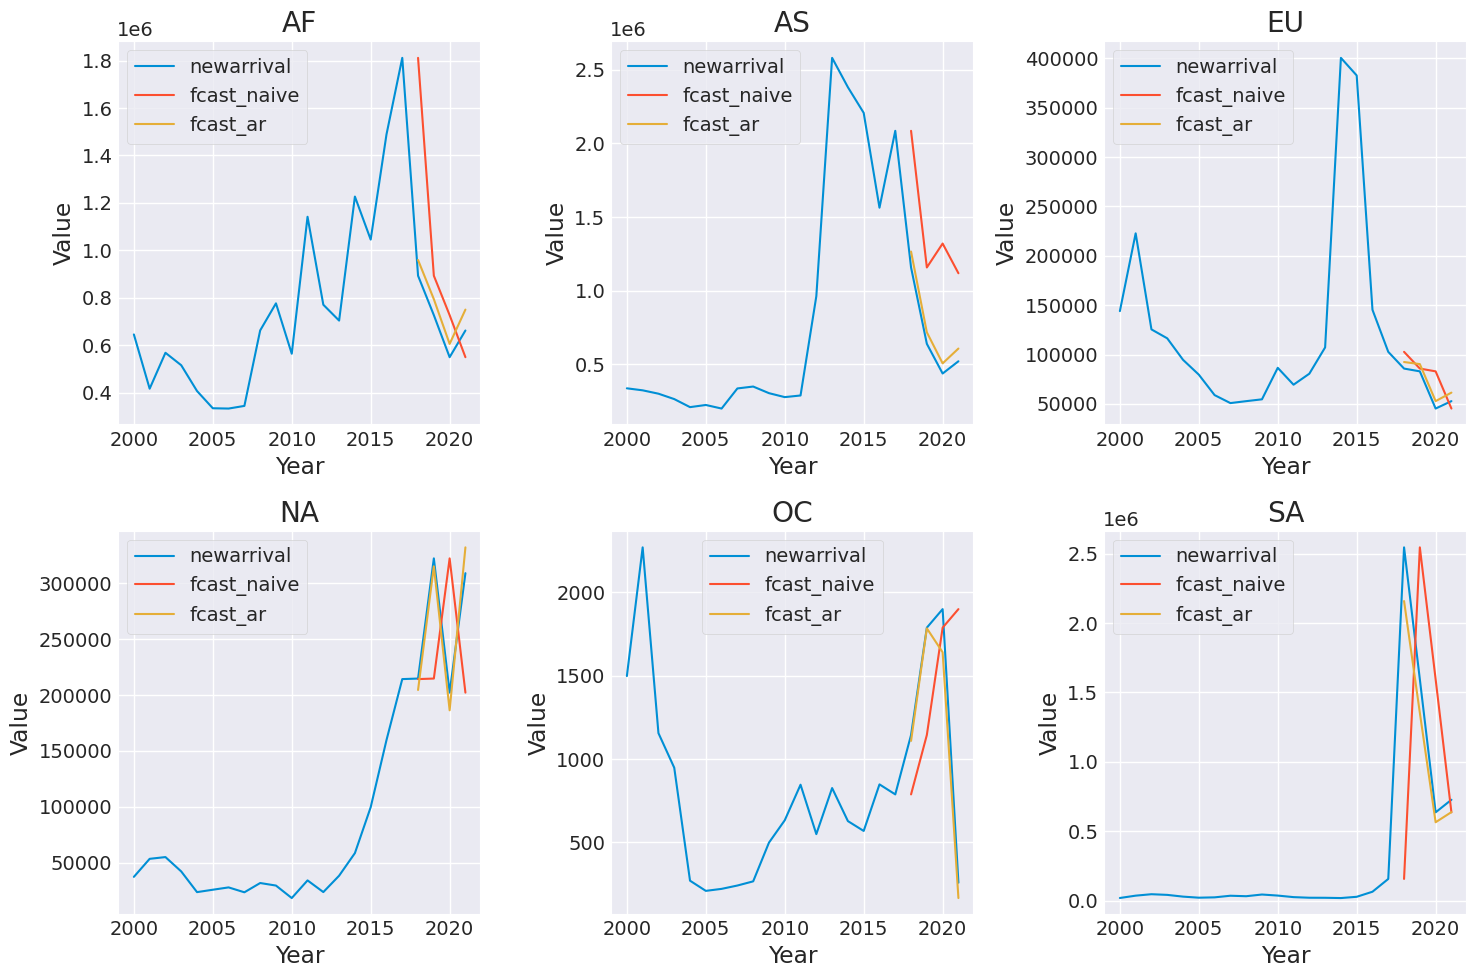

In [851]:
# Get the unique continents in the DataFrame
continents = grouped['continent_o'].unique()

# Set the number of rows and columns for the subplot grid
num_rows = 2  # Adjust the number of rows as per your preference
num_cols = (len(continents) + num_rows - 1) // num_rows

# Create a subplot grid with the specified number of rows and columns
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))

# Flatten the subplot grid to access each individual subplot
axes = axes.flatten()

# Iterate over the unique continents and plot the data for each continent
for i, continent in enumerate(continents):
    # Filter the DataFrame for the current continent
    continent_grouped = grouped[grouped['continent_o'] == continent]
    
    # Plot the data for "newarrival" and "fcast_newarrival_naive" for the current continent
    axes[i].plot(continent_grouped['year'], continent_grouped['newarrival'], label='newarrival')
    axes[i].plot(continent_grouped['year'], continent_grouped['fcast_newarrival_naive'], label='fcast_naive')
    axes[i].plot(continent_grouped['year'], continent_grouped['fcast_newarrival_ar'], label='fcast_ar')
    
    # Set the title and labels for the current subplot
    axes[i].set_title(continent)
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Value')
    
    # Display the legend for the current subplot
    axes[i].legend()

# Adjust the layout to prevent overlapping of subplots
plt.tight_layout()

# Show the plot
plt.show()


## Metrics

In [847]:
# Compute RMSE for each row
import math
df_error = df_forecast.loc[(df_forecast.year >= start_year) & (df_forecast.year <= end_year)]
df_error['naive_error'] = ((df_error['newarrival'] - df_error['fcast_newarrival_naive']) ** 2).apply(math.sqrt)
df_error['ar_error'] = ((df_error['newarrival'] - df_error['fcast_newarrival_ar']) ** 2).apply(math.sqrt)
df_error

/tmp/ipykernel_2947/3476627916.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['naive_error'] = ((df_error['newarrival'] - df_error['fcast_newarrival_naive']) ** 2).apply(math.sqrt)
/tmp/ipykernel_2947/3476627916.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['ar_error'] = ((df_error['newarrival'] - df_error['fcast_newarrival_ar']) ** 2).apply(math.sqrt)


,continent_o,Unnamed: 0,iso_o,iso_d,Id,year,ref_outflow,ratio,check,fcast_ratio_ar,newarrival,fcast_newarrival_naive,fcast_newarrival_ar,naive_error,ar_error
18,NA,18,ABW,AFG,ABWAFG,2018,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
19,NA,19,ABW,AFG,ABWAFG,2019,1.0,0.000000,1.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
20,NA,20,ABW,AFG,ABWAFG,2020,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
21,NA,21,ABW,AFG,ABWAFG,2021,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
40,NA,40,ABW,AGO,ABWAGO,2018,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
840817,AF,840817,ZWE,ZAF,ZWEZAF,2021,640.0,0.000000,1.0,0.653973,0.0,214.0,418.542623,214.0,418.542623
840836,AF,840836,ZWE,ZMB,ZWEZMB,2018,1908.0,0.001048,1.0,0.000125,2.0,0.0,0.238036,2.0,1.761964
840837,AF,840837,ZWE,ZMB,ZWEZMB,2019,3371.0,0.000000,1.0,0.000331,0.0,2.0,1.115228,2.0,1.115228
840838,AF,840838,ZWE,ZMB,ZWEZMB,2020,1196.0,0.000836,1.0,0.000199,1.0,0.0,0.238234,1.0,0.761766


In [848]:
# Define the ranges for grouping the actual values
ranges = [0, 10, 100, 1000,10000,100000, 1200000]  # Modify the ranges as per your requirements
labels = ['0-10', '10-100', '100-1k', '1k-10k','10k-100k','100k+']  # Labels for the groups
# Group the errors based on ranges of actual values
df_error['actual_range'] = pd.cut(df_error['newarrival'], ranges, labels=labels, include_lowest=True)

# Compute mean RMSE for each group
grouped_errors = df_error[['naive_error', 'ar_error','actual_range']].groupby('actual_range').mean()
grouped_errors


/tmp/ipykernel_2947/664487991.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_error['actual_range'] = pd.cut(df_error['newarrival'], ranges, labels=labels, include_lowest=True)


,naive_error,ar_error
actual_range,,
0-10,2.033201,2.177284
10-100,36.209227,85.008997
100-1k,280.194662,435.774549
1k-10k,2386.465937,2122.454337
10k-100k,31011.180556,22998.328057
100k+,240486.625000,160154.674045


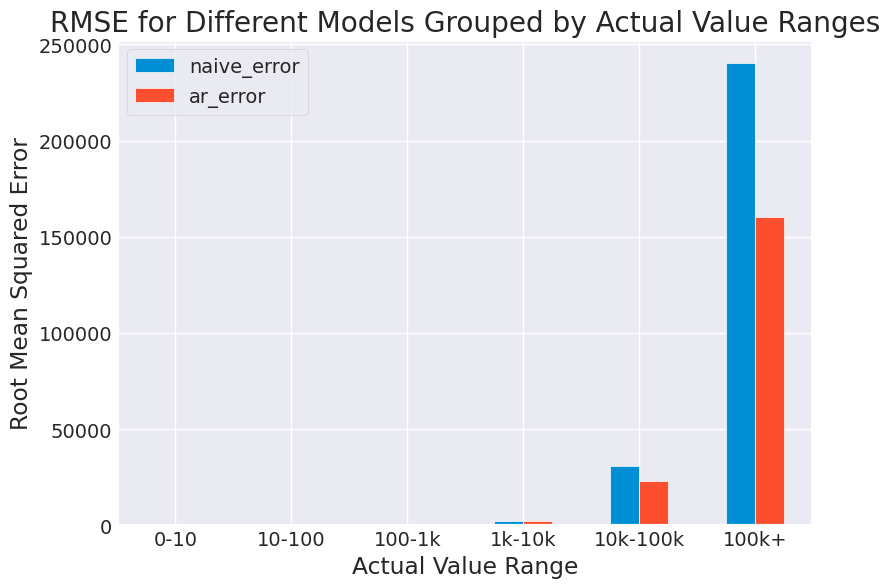

In [852]:
# Plot the bar plot
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style('darkgrid')
grouped_errors.plot(kind='bar', figsize=(8, 6))
plt.xlabel('Actual Value Range')
plt.ylabel('Root Mean Squared Error')
plt.title('RMSE for Different Models Grouped by Actual Value Ranges')
plt.xticks(rotation=0)
# plt.yscale('log')
plt.legend()
plt.show()
